In [26]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
data = pickle.load(open('data0.pickle', 'rb'))

In [3]:
# speed limit - 0   ----> 0
# no passing - 9    ----> 1
# yield - 13        ----> 2
# stop - 14         ----> 3  
# pedestrian - 27   ----> 4

In [4]:
# load data

x_train = data['x_train']
y_train = data['y_train']
x_data = []
y_data = []

for i in range(len(y_train)):
    if y_train[i] == 0:
        x_data.append(x_train[i])
        y_data.append(0)
    if y_train[i] == 9:
        x_data.append(x_train[i])
        y_data.append(1)
    if y_train[i] == 13:
        x_data.append(x_train[i])
        y_data.append(2)
    if y_train[i] == 14:
        x_data.append(x_train[i])
        y_data.append(3)
    if y_train[i] == 27:
        x_data.append(x_train[i])
        y_data.append(4)
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

In [5]:
y_data.shape

(10115,)

In [6]:
import torch
import torch.nn as nn
# import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import glob, os
# import scipy.misc
from PIL import Image
import numpy as np
import random

In [7]:
data = []
for i in range(len(x_data)):    
    data.append({
        'label': y_data[i],
        'img': x_data[i]
    })

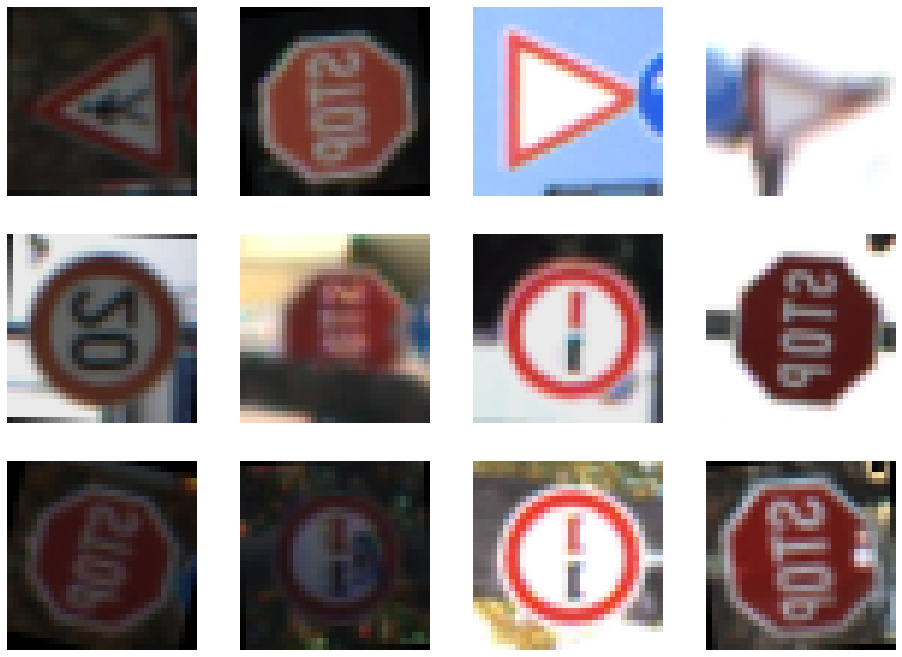

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 16
next_pic = [np.swapaxes(data[i]['img'],0,2) for i in range(12)]

for i, img in enumerate(next_pic):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    plt.imshow(img)

plt.show()

In [9]:
class Nnet(nn.Module):

    def __init__(self):
        super(Nnet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 21 , 3, stride=1, padding=1, bias=False), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(21, 20, 3,stride=1, padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(20, 15, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU( inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(15,7, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(7),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(7168, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 5),
            #nn.Softmax()
        )
    def num_flat_features(self, inputs):
        
        # Get the dimensions of the layers excluding the inputs
        size = inputs.size()[1:]
        # Track the number of features
        num_features = 1
        
        for s in size:
            num_features *= s
        
        return num_features

    def forward(self, input):
        #print(input.shape)
        input = input.view(100,3,32,32)
        x=self.main(input.float())
        x=x.view(x.shape[0], self.num_flat_features(x))
        return self.fc(x)

In [10]:
'''
  Step 2: Make Data iterable
'''

# separate train data and test data

# random.shuffle(data) # with no seed
random.Random(10).shuffle(data) # with seed to ensure consistency

num_test = 1000
num_valid = 1000
# get some sample as test, aka target
test_data = data[0:num_test]
valid_data = data[num_test:num_test+num_valid]
train_data  = data[num_test+num_valid:-1]
train_data = train_data[0:int(len(train_data)/100)*100]

# batch size is how many sample to go through each "step"
batch_size = 100
# how many batch size to go through totally
n_iters = 2000
# times going through the whole data
num_epochs = int(n_iters * batch_size / (len(train_data)))
#num_epochs = 30

# make data iterable
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
model = Nnet()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
'''
  Step 7: train model
'''

iter = 0
total = 0
correct = 0
training_losses = []
validation_losses = []
test_accuracy = []
train_loss = 0
valid_loss = 0

for epoch in range(num_epochs):
    print("-------Epoch {}/{}-------".format(epoch + 1, num_epochs))
    for i, batch in enumerate(train_loader):
        iter += 1
        labels = batch['label']
        images = batch['img']

        # was tensor, wrap in Variable, so we can accumulate gradients
        images = Variable(images)
        labels = Variable(labels)

        # clear cumulated gradients
        optimizer.zero_grad()
        
        # to cuda
        # images, labels = images.to(computing_device), labels.to(computing_device)
        
        # get the predictions of our model
        output = model(images)

        # calculate loss
        loss = criterion(output, labels)
        train_loss += loss.data.item()
        
        # gradient descent
        loss.backward()

        # update weights according to gradients 
        optimizer.step()

        if i % 5 == 0:
            print("mini-batch {}, loss: {}".format(i, loss.data.item()/ len(batch)))
            
    training_losses.append(train_loss / len(train_data))
    train_loss = 0

            
    for i, batch in enumerate(valid_loader):
        iter += 1
        labels = batch['label']
        images = batch['img']

        # was tensor, wrap in Variable, so we can accumulate gradients
        images = Variable(images)
        labels = Variable(labels)
        
        # get the predictions of our model
        output = model(images)

        # calculate loss
        loss = criterion(output, labels)
        
        valid_loss += loss.data.item()

    validation_losses.append(valid_loss / len(valid_data))
    valid_loss = 0


            
            
    # loop all test
    for i, batch in enumerate(test_loader):
        t_labels = batch['label']
        t_images = batch['img']

        t_images = Variable(torch.unsqueeze(t_images,1))
            
        #t_images, t_labels = t_images.to(computing_device), t_labels.to(computing_device)
            
        t_out = model(t_images)

        _, precicted = torch.max(t_out, 1)

        total += t_labels.size(0)

        # num of correct shapes predicted
        correct += (precicted == t_labels).sum().item()

    accuracy = correct / total
    #if i % 10 == 0:
    test_accuracy.append(accuracy)
    print('Iteration: {}. Loss: {}. Accuracy: {:.2%}'.format(iter, loss.data.item(), accuracy))

-------Epoch 1/24-------
mini-batch 0, loss: 0.8077344298362732
mini-batch 5, loss: 4.801959037780762
mini-batch 10, loss: 1.2012288570404053
mini-batch 15, loss: 0.7825784087181091
mini-batch 20, loss: 0.7697437405586243
mini-batch 25, loss: 0.6499762535095215
mini-batch 30, loss: 0.6179037690162659
mini-batch 35, loss: 0.4191969037055969
mini-batch 40, loss: 0.4593929946422577
mini-batch 45, loss: 0.29253119230270386
mini-batch 50, loss: 0.30489659309387207
mini-batch 55, loss: 0.2309248149394989
mini-batch 60, loss: 0.2602204978466034
mini-batch 65, loss: 0.1488468050956726
mini-batch 70, loss: 0.14792998135089874
mini-batch 75, loss: 0.09102888405323029
mini-batch 80, loss: 0.06262055039405823
Iteration: 91. Loss: 0.15615397691726685. Accuracy: 94.40%
-------Epoch 2/24-------
mini-batch 0, loss: 0.05088670551776886
mini-batch 5, loss: 0.08679809421300888
mini-batch 10, loss: 0.05307936668395996
mini-batch 15, loss: 0.055333904922008514
mini-batch 20, loss: 0.043613649904727936
mini

mini-batch 25, loss: 0.0006631875294260681
mini-batch 30, loss: 0.00016291139763779938
mini-batch 35, loss: 0.0032872362062335014
mini-batch 40, loss: 0.0006780322873964906
mini-batch 45, loss: 0.0005427116993814707
mini-batch 50, loss: 0.0006065648631192744
mini-batch 55, loss: 0.006167902145534754
mini-batch 60, loss: 0.00013711613428313285
mini-batch 65, loss: 0.0005973104853183031
mini-batch 70, loss: 0.007218809798359871
mini-batch 75, loss: 0.0002979475539177656
mini-batch 80, loss: 0.0008793742163106799
Iteration: 1001. Loss: 0.003096642205491662. Accuracy: 98.85%
-------Epoch 12/24-------
mini-batch 0, loss: 0.00014909989840816706
mini-batch 5, loss: 0.00656109256669879
mini-batch 10, loss: 8.087938476819545e-05
mini-batch 15, loss: 0.0022802019957453012
mini-batch 20, loss: 0.00022477192396763712
mini-batch 25, loss: 0.0015261650551110506
mini-batch 30, loss: 0.015096820890903473
mini-batch 35, loss: 0.001427359995432198
mini-batch 40, loss: 0.003017895156517625
mini-batch 45,

mini-batch 35, loss: 2.4103219402604736e-05
mini-batch 40, loss: 0.0002866269205696881
mini-batch 45, loss: 0.0005139010027050972
mini-batch 50, loss: 0.0027356338687241077
mini-batch 55, loss: 0.003013553563505411
mini-batch 60, loss: 0.009877248667180538
mini-batch 65, loss: 0.002499848371371627
mini-batch 70, loss: 5.5501466704299673e-05
mini-batch 75, loss: 4.03805315727368e-05
mini-batch 80, loss: 0.012296007014811039
Iteration: 1911. Loss: 0.0013305115280672908. Accuracy: 99.34%
-------Epoch 22/24-------
mini-batch 0, loss: 2.6319508833694272e-05
mini-batch 5, loss: 0.0013983574463054538
mini-batch 10, loss: 0.005455858539789915
mini-batch 15, loss: 0.0033873480278998613
mini-batch 20, loss: 0.011495889164507389
mini-batch 25, loss: 1.1832495147245936e-05
mini-batch 30, loss: 6.389045302057639e-05
mini-batch 35, loss: 4.0817612898536026e-05
mini-batch 40, loss: 6.433723319787532e-05
mini-batch 45, loss: 3.858647687593475e-05
mini-batch 50, loss: 8.614938451501075e-06
mini-batch 5

In [13]:
len(test_accuracy)

24

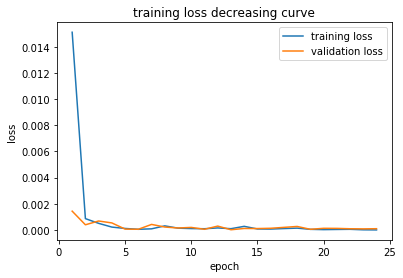

In [23]:
plt.plot(range(1,25), training_losses, label='training loss')
plt.plot(range(1,25), validation_losses, label='validation loss')
#plt.axvline(x=20, color='r', linestyle='--', label='best model')
#text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss decreasing curve')
plt.savefig('training_loss')

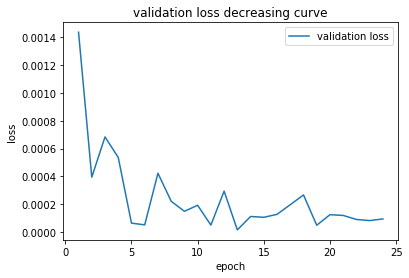

In [18]:
plt.plot(range(1,25), validation_losses, label='validation loss')
#plt.plot(range(1,26), training_losses, label='training loss')
#plt.axvline(x=20, color='r', linestyle='--', label='best model')
#text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('validation loss decreasing curve')
plt.savefig('validation_loss')

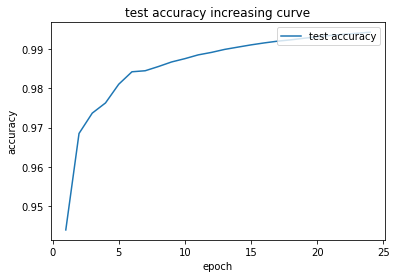

In [24]:
plt.plot(range(1,25), test_accuracy, label='test accuracy')
#plt.plot(range(1,26), training_losses, label='training loss')
#plt.axvline(x=20, color='r', linestyle='--', label='best model')
#text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('test accuracy increasing curve')
plt.savefig('test_accuracy')

In [25]:
import pickle
import matplotlib.pyplot as plt